In [11]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import rulevetting.api.viz as viz

from rulevetting.projects.csi_pecarn.dataset_as import Dataset # are we still importing from csi?
from rulevetting.projects.csi_pecarn import helper

outcome_def = 'outcome'  # output
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
helper.get_outcomes

<function rulevetting.projects.csi_pecarn.helper.get_outcomes(RAW_DATA_PATH, NUM_PATIENTS=12044)>

In [13]:
import rulevetting
import os
from os.path import join as oj
from tqdm import tqdm
from typing import Dict

print(f'{"DATA_PATH:":>15}', rulevetting.DATA_PATH)
print(f'{"REPO_PATH:":>15}', rulevetting.REPO_PATH)
print(f'{"MRULES_PATH:":>15}', rulevetting.MRULES_PATH)
print(f'{"PROJECTS_PATH:":>15}', rulevetting.PROJECTS_PATH)

     DATA_PATH: /Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-vetting/data
     REPO_PATH: /Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-vetting
   MRULES_PATH: /Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-vetting/rulevetting
 PROJECTS_PATH: /Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-vetting/rulevetting/projects


# Briefly check data

In [14]:
data_path: str = rulevetting.DATA_PATH
raw_data_path = oj(data_path, "csi_pecarn", 'raw')

fnames = sorted([
    fname for fname in os.listdir(raw_data_path)
    if 'csv' in fname
    #   and not 'radiology' in fname
    #   and not 'kappa' in fname
    ])  # remove outcome (SH: not yet)

r = {}
print('read all the csvs...', fnames)
if len(fnames) == 0:
    print('no csvs found in path', raw_data_path)
for fname in tqdm(fnames):
    df = pd.read_csv(oj(raw_data_path, fname), encoding="ISO-8859-1")
    df.rename(columns={'site': 'SiteID'}, inplace=True)
    df.rename(columns={'SITE': 'SiteID'}, inplace=True)
    df.rename(columns={'caseid': 'CaseID'}, inplace=True)
    df.rename(columns={'controltype': 'ControlType'}, inplace=True)
    df.rename(columns={'studysubjectid': 'SubjectID'}, inplace=True)
    df.rename(columns={'StudySubjectID': 'SubjectID'}, inplace=True)
    assert ('SiteID' in df.keys())
    assert ('CaseID' in df.keys())
    assert ('ControlType' in df.keys())
    assert ('SubjectID' in df.keys())
    r[fname] = df

read all the csvs... ['analysisvariables.csv', 'clinicalpresentationfield.csv', 'clinicalpresentationoutside.csv', 'clinicalpresentationsite.csv', 'demographics.csv', 'injuryclassification.csv', 'injurymechanism.csv', 'kappa.csv', 'medicalhistory.csv', 'radiologyoutside.csv', 'radiologyreview.csv', 'radiologysite.csv']


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 69.39it/s]


In [15]:
print(fname)
fnames

radiologysite.csv


['analysisvariables.csv',
 'clinicalpresentationfield.csv',
 'clinicalpresentationoutside.csv',
 'clinicalpresentationsite.csv',
 'demographics.csv',
 'injuryclassification.csv',
 'injurymechanism.csv',
 'kappa.csv',
 'medicalhistory.csv',
 'radiologyoutside.csv',
 'radiologyreview.csv',
 'radiologysite.csv']

In [16]:
print(r.keys())
for fname in fnames:
    df = r[fname]
    print(f'{fname:>35}', df.shape)

dict_keys(['analysisvariables.csv', 'clinicalpresentationfield.csv', 'clinicalpresentationoutside.csv', 'clinicalpresentationsite.csv', 'demographics.csv', 'injuryclassification.csv', 'injurymechanism.csv', 'kappa.csv', 'medicalhistory.csv', 'radiologyoutside.csv', 'radiologyreview.csv', 'radiologysite.csv'])
              analysisvariables.csv (3314, 36)
      clinicalpresentationfield.csv (3314, 101)
    clinicalpresentationoutside.csv (3314, 114)
       clinicalpresentationsite.csv (3314, 136)
                   demographics.csv (3314, 11)
           injuryclassification.csv (540, 208)
                injurymechanism.csv (3314, 35)
                          kappa.csv (365, 124)
                 medicalhistory.csv (3314, 32)
               radiologyoutside.csv (3314, 16)
                radiologyreview.csv (445, 16)
                  radiologysite.csv (3314, 15)


injuryclassfication / kappa / radiologyreview : less rows than others

In [17]:
print("Check unique SubjectID for each .csv")
a = 0
for fname in fnames:
    df = r[fname]
    if df.shape[0] != len(pd.unique(df.SubjectID)):
        a += 1
        print(fname)
if(a==0):
    print("ALL .csv file has unique SubjectID")

Check unique SubjectID for each .csv
ALL .csv file has unique SubjectID


In [18]:
fnames_small = [fname for fname in fnames
                if not 'radiology' in fname
                    and not 'kappa' in fname
                    and not 'injuryclassification' in fname
                    and not 'outside' in fname
                    and not 'onfield' in fname
                    and not 'medicalhistory' in fname]
print(fnames_small)

cols = 0
rows = 0

df_features = r[fnames_small[0]]
print('merge all the dfs...')
for i, fname in tqdm(enumerate(fnames_small)):
    df2 = r[fname].copy()
    # if subj has multiple entries, only keep first
    df2 = df2.drop_duplicates(subset=['SubjectID'], keep='last')
    # don't save duplicate columns
    df_features = df_features.set_index('SubjectID').combine_first(df2.set_index('SubjectID')).reset_index()
    # SH: check the number ofcolumns
    rows += df2.shape[0]
    cols += df2.shape[1]

['analysisvariables.csv', 'clinicalpresentationsite.csv', 'demographics.csv', 'injurymechanism.csv']
merge all the dfs...


4it [00:00, 11.98it/s]


In [19]:
print(rows, cols)
print(len(df_features.columns))
print(len(pd.unique(df_features.columns)))
print(df_features.shape)

13256 218
206
206
(3314, 206)


In [20]:
var_use = ['AVPU', 'AgeInYears', 'AlteredMentalStatus', 'ArrPtIntub', 'Assault',
           'AxialLoadAnyDoc', 'CaseID', 'CervicalSpineImmobilization', 'ChildAbuse', 'ControlType',
           'DxCspineInjury', 'Ethnicity', 'FallDownStairs', 'FallFromElevation', 'FocalNeuroFindings',
           'Gender', 'HeadFirst', 'HighriskDiving', 'HighriskFall', 'HighriskHanging',
           'HighriskHitByCar', 'HighriskMVC', 'HighriskOtherMV', 'InjuryPrimaryMechanism', 'IntervForCervicalStab',
           'LOC', 'LimitedRangeMotion','LongTermRehab', 'Predisposed', "MedsGiven",
           "MedsRecdPriorArrival", "MotorGCS", "PainNeck", "PainNeck2", "PassRestraint",
           "PosMidNeckTenderness", 'PosMidNeckTenderness2',"PtAmbulatoryPriorArrival", "PtCompPain"]

## Andy and Licong's features including outcome

In [21]:
df = df_features[var_use]
df.to_csv("df_old.csv", index=False)
df = helper.rename_values(df)

/Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [22]:
df.to_csv("df_andy.csv", index=False)

The difference between `cols` and `df_features.shape[1]` = 4 * (`len(fnames_small)`-1) 
(because of `SiteID`, `CaseID`, `ControlType`, `SubjectID`)

In [23]:
# SH: NO outcomes yet
# df_outcomes = helper.get_outcomes(raw_data_path)

In [24]:
#df = df_features
#df = r[fnames[0]]
processed_feats = df.keys().values.tolist()
processed_feats
print(len(processed_feats))

39


In [25]:
temp = df.var(axis = 0, skipna = True, numeric_only = True) == 0
const_var = []
for i in temp.index:
    if temp[i]:
#        print(i)
        const_var.append(i)
print(const_var)

[]


In [26]:
df[const_var]

""
0
1
2
3
4
...
3309
3310
3311
3312


In [27]:
#print(df["ControlType"].unique())
#df = df.assign(outcome=lambda x: (x.ControlType == 'case').astype(int))
#df.drop(columns = "ControlType")

In [28]:
#print(df.dtypes)
dc = {}
for t in df.dtypes:
    if t in dc.keys():
        dc[t] = dc[t] +1
    else:
        dc[t] = 1
print(dc)

{dtype('float64'): 33, dtype('int64'): 3, dtype('O'): 3}


There is no Boolean column

### Choose only valid(numeric) columns

In [29]:
valids = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = df.select_dtypes(include=valids)

In [30]:
newdf

,AVPU,AgeInYears,AlteredMentalStatus,ArrPtIntub,Assault,AxialLoadAnyDoc,CaseID,CervicalSpineImmobilization,ChildAbuse,ControlType,...,MedsGiven,MedsRecdPriorArrival,MotorGCS,PainNeck,PainNeck2,PassRestraint,PosMidNeckTenderness,PosMidNeckTenderness2,PtAmbulatoryPriorArrival,PtCompPain
0,1.0,15.71,1.0,1.0,NaN,0,110001,1,NaN,1.0,...,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
1,1.0,15.94,0.0,0.0,NaN,0,110002,1,NaN,1.0,...,1.0,0.0,1.0,1.0,1.0,NaN,1.0,1.0,0.0,1.0
2,1.0,14.53,0.0,0.0,NaN,1,110003,3,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,0.0,1.0
3,1.0,14.96,0.0,0.0,NaN,1,110004,1,NaN,1.0,...,1.0,0.0,NaN,1.0,1.0,NaN,1.0,1.0,0.0,1.0
4,0.0,13.23,NaN,0.0,NaN,1,110005,3,NaN,1.0,...,0.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,1.0,2.97,0.0,0.0,NaN,0,1713113,3,NaN,0.0,...,1.0,0.0,1.0,0.0,0.0,NaN,1.0,1.0,0.0,1.0
3310,1.0,12.82,0.0,0.0,NaN,0,1713132,1,NaN,0.0,...,0.0,0.0,NaN,1.0,1.0,NaN,0.0,0.0,0.0,1.0
3311,1.0,0.82,0.0,0.0,NaN,0,1713122,1,NaN,0.0,...,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0
3312,1.0,0.11,0.0,0.0,NaN,1,1713105,3,NaN,0.0,...,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0


### Check invalid columns

In [31]:
invalid_columns = df.columns[df.dtypes == "object"]
print(len(invalid_columns))
print(invalid_columns)

3
Index(['Ethnicity', 'Gender', 'InjuryPrimaryMechanism'], dtype='object')


In [32]:
i = 0
for c in invalid_columns:
    temp = df.select_dtypes(include="object")[c].unique()
    if len(temp) <= 30:
        #print(c)
        #print(temp, "\n")
        i += 1
print(i)

3


In [33]:
# SH: not included in "newdf" yet
additional_valid_columns = ["AVPU",  "ArrPtIntub", "DxCspineInjury", "Ethnicity", "Gender",
                            "HeadFirst", "HeadFirstRegion", "InjuryPrimaryMechanism", "IntervForCervicalStab", "LimitedRangeMotion",
                            "LongTermRehab", "MedsGiven", "MedsRecdPriorArrival", "MinorInjuries", "PtAmbulatoryPriorArrival",
                            "PtCompPain", "PtCompPainNeckMove", "PtExtremityWeakness", "PtParesthesias", "PtSensoryLoss",
                            "PtTender", "TotalGCS", "clotheslining", "helmet"]
# 34 variables

### Plot correlation heatmap

In [34]:
nonconst_var = np.setdiff1d(np.asarray(newdf.columns), const_var)
print(len(np.asarray(newdf.columns)))
print(len(const_var))
print(len(nonconst_var))
newdf = newdf[nonconst_var]

36
0
36


In [35]:
# pandas impute missing values with median
newdf = newdf.fillna(df.median(numeric_only = True))
print(len(newdf.columns))

36


In [36]:
newdf[nonconst_var].head()

,AVPU,AgeInYears,AlteredMentalStatus,ArrPtIntub,Assault,AxialLoadAnyDoc,CaseID,CervicalSpineImmobilization,ChildAbuse,ControlType,...,MedsRecdPriorArrival,MotorGCS,PainNeck,PainNeck2,PassRestraint,PosMidNeckTenderness,PosMidNeckTenderness2,Predisposed,PtAmbulatoryPriorArrival,PtCompPain
0,1.0,15.71,1.0,1.0,1.0,0,110001,1,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,15.94,0.0,0.0,1.0,0,110002,1,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
2,1.0,14.53,0.0,0.0,1.0,1,110003,3,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
3,1.0,14.96,0.0,0.0,1.0,1,110004,1,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
4,0.0,13.23,0.0,0.0,1.0,1,110005,3,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [37]:
#corrs = df[processed_feats].corr(method='pearson')
corrs = newdf[nonconst_var].corr(method='pearson')
print(corrs.shape)
#print(corrs)

(36, 36)


In [38]:
corrs.isna().sum().sum()

0

In [39]:
corrs

,AVPU,AgeInYears,AlteredMentalStatus,ArrPtIntub,Assault,AxialLoadAnyDoc,CaseID,CervicalSpineImmobilization,ChildAbuse,ControlType,...,MedsRecdPriorArrival,MotorGCS,PainNeck,PainNeck2,PassRestraint,PosMidNeckTenderness,PosMidNeckTenderness2,Predisposed,PtAmbulatoryPriorArrival,PtCompPain
AVPU,1.000000,-0.027646,-0.117688,-0.185422,-0.016441,0.011010,0.132563,-0.028155,0.021313,-0.039466,...,-0.060752,0.130613,0.020671,0.026302,0.001388,0.031549,0.036393,-0.005620,0.004542,-0.039073
AgeInYears,-0.027646,1.000000,-0.124931,-0.051018,0.038715,0.111221,-0.063631,-0.041602,-0.130142,0.042423,...,0.043534,0.095659,0.223539,0.256150,-0.014467,0.259530,0.270407,-0.055342,0.076049,0.395169
AlteredMentalStatus,-0.117688,-0.124931,1.000000,0.510629,0.014560,-0.066043,0.057131,-0.109161,0.058590,0.116753,...,0.192679,-0.659140,-0.268341,-0.282279,-0.069194,-0.223673,-0.231972,-0.028378,-0.140970,-0.053782
ArrPtIntub,-0.185422,-0.051018,0.510629,1.000000,0.001587,-0.078148,0.055374,-0.096620,0.030769,0.167632,...,0.399652,-0.528127,-0.181418,-0.188374,-0.084621,-0.155122,-0.158141,-0.005296,-0.090732,0.103379
Assault,-0.016441,0.038715,0.014560,0.001587,1.000000,-0.084000,-0.019803,-0.010476,-0.009608,0.031318,...,-0.009124,-0.005724,-0.017312,-0.027971,-0.054452,-0.026075,-0.020982,-0.006946,-0.019456,0.028102
AxialLoadAnyDoc,0.011010,0.111221,-0.066043,-0.078148,-0.084000,1.000000,-0.028372,0.011597,-0.023941,0.071673,...,0.021022,0.081445,0.124911,0.144360,0.083162,0.134601,0.150128,0.006286,0.014579,-0.019422
CaseID,0.132563,-0.063631,0.057131,0.055374,-0.019803,-0.028372,1.000000,-0.048962,0.009917,-0.004667,...,0.013236,-0.088722,-0.087324,-0.094248,-0.027770,-0.091450,-0.087456,0.031384,-0.010550,-0.024635
CervicalSpineImmobilization,-0.028155,-0.041602,-0.109161,-0.096620,-0.010476,0.011597,-0.048962,1.000000,0.059946,-0.071691,...,-0.000142,0.078109,0.188760,0.140984,0.065684,0.103224,0.085593,0.044903,0.563147,0.048789
ChildAbuse,0.021313,-0.130142,0.058590,0.030769,-0.009608,-0.023941,0.009917,0.059946,1.000000,-0.001038,...,0.030246,-0.033058,-0.054072,-0.051794,0.023203,-0.038149,-0.040868,-0.006208,-0.014397,-0.089297
ControlType,-0.039466,0.042423,0.116753,0.167632,0.031318,0.071673,-0.004667,-0.071691,-0.001038,1.000000,...,0.216190,-0.126488,0.123322,0.168644,-0.037675,0.045778,0.086591,0.064546,-0.027865,0.028657


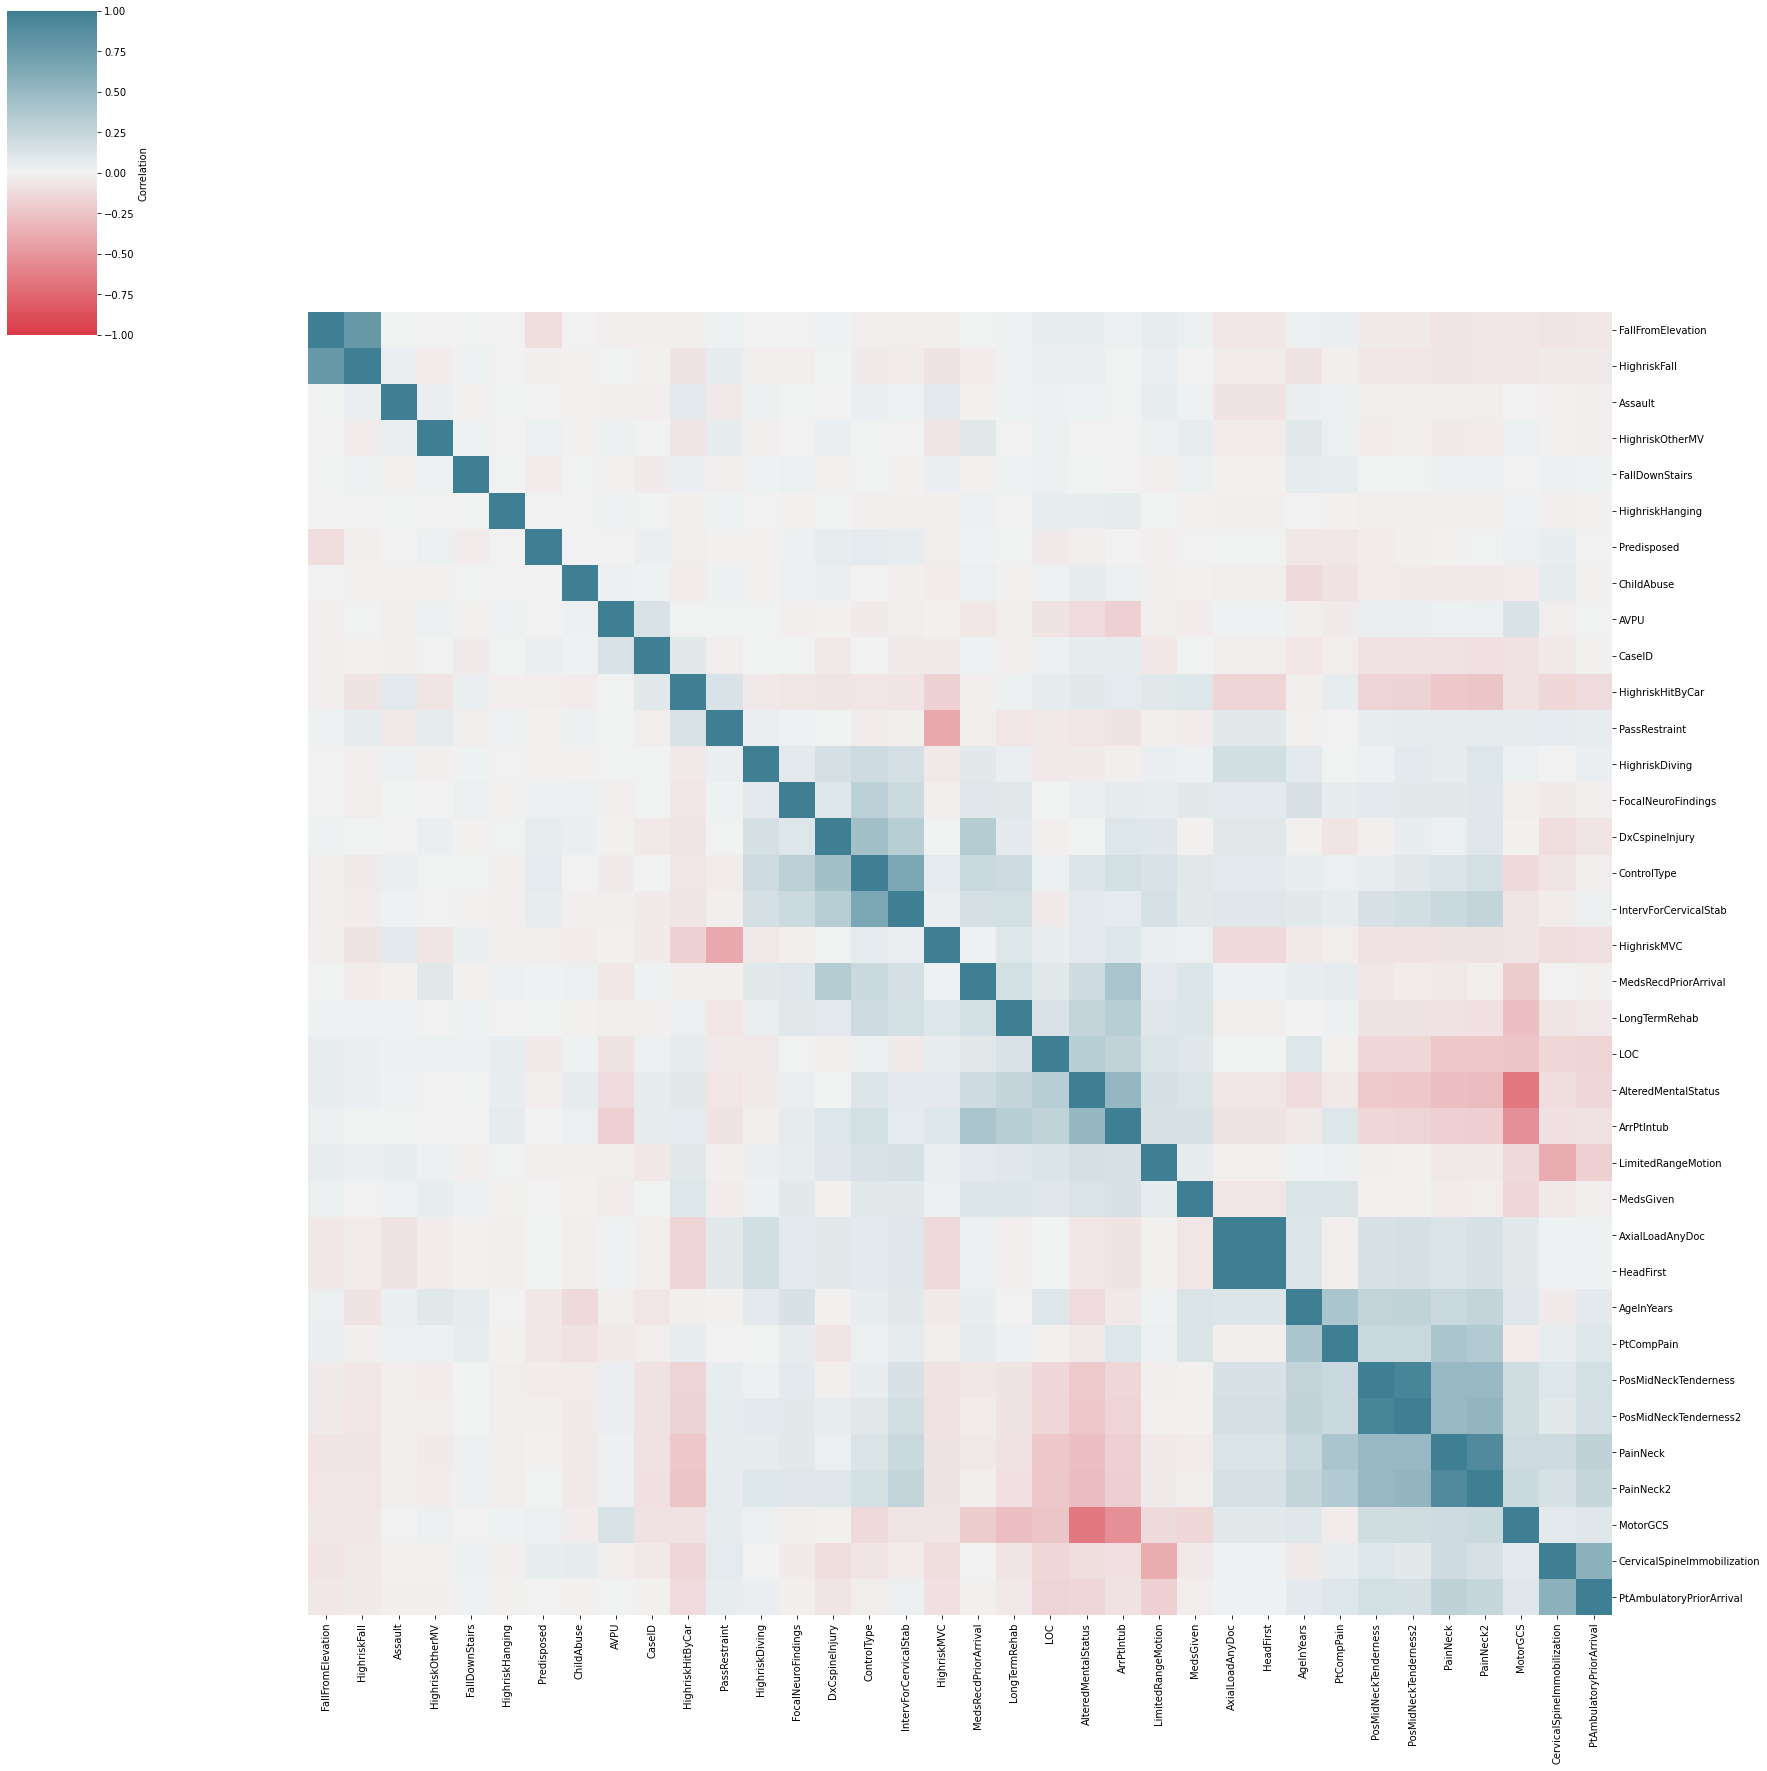

In [40]:
corrmap = sns.clustermap(corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'}, yticklabels=True, figsize=(25, 25))
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)

### Individual correlations with outcomes

In [41]:
outcome_def = 'ControlType'

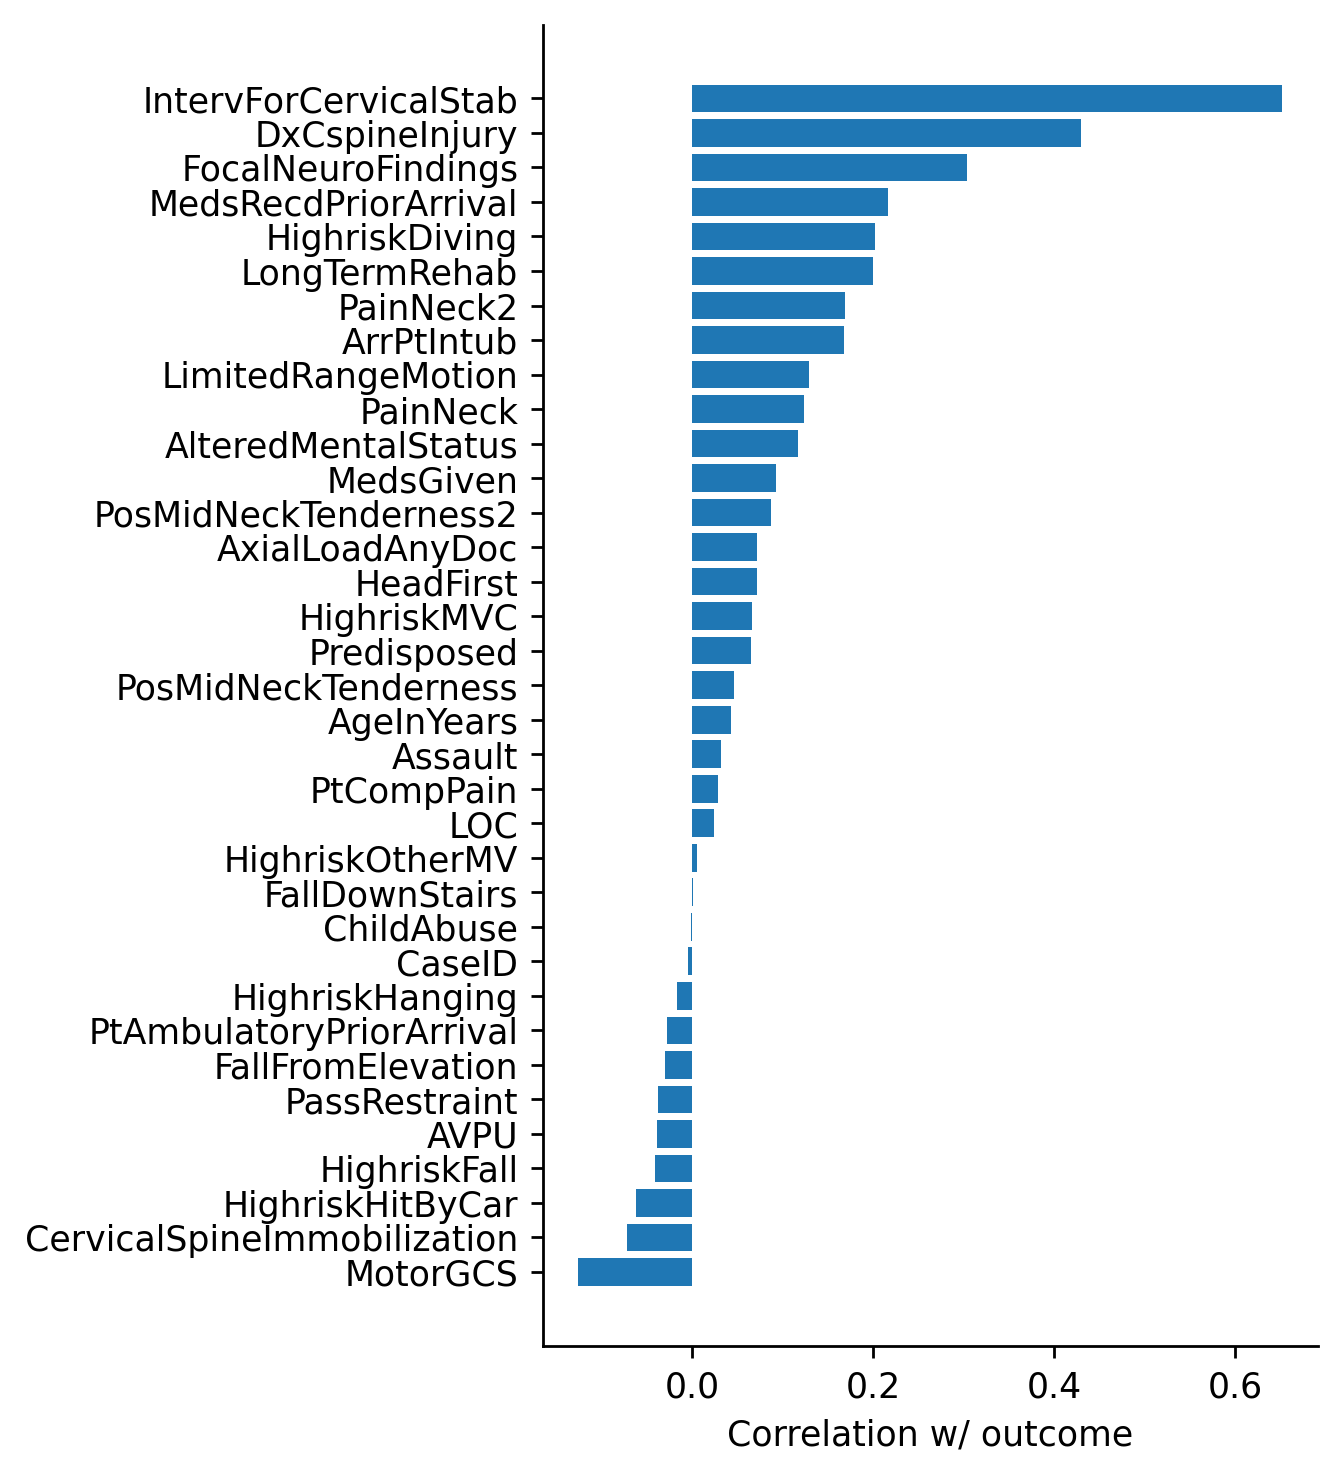

In [42]:
plt.figure(dpi=250, figsize=(4, 7))
vals = corrs[outcome_def]
vals.head()
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:-1], vals[args][:-1])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Scatterplot of continuous features

In [65]:
cont_df = newdf[nonconst_var]
list(cont_df.columns)

['AVPU',
 'AgeInYears',
 'AlteredMentalStatus',
 'ArrPtIntub',
 'Assault',
 'AxialLoadAnyDoc',
 'CaseID',
 'CervicalSpineImmobilization',
 'ChildAbuse',
 'DxCspineInjury',
 'FallDownStairs',
 'FallFromElevation',
 'FocalNeuroFindings',
 'HeadFirst',
 'HighriskDiving',
 'HighriskFall',
 'HighriskHanging',
 'HighriskHitByCar',
 'HighriskMVC',
 'HighriskOtherMV',
 'IntervForCervicalStab',
 'LOC',
 'LimitedRangeMotion',
 'LongTermRehab',
 'MedsGiven',
 'MedsRecdPriorArrival',
 'MotorGCS',
 'PainNeck',
 'PainNeck2',
 'PassRestraint',
 'PosMidNeckTenderness',
 'PosMidNeckTenderness2',
 'Predisposed',
 'outcome']

ValueError: num must be 1 <= num <= 2, not 3

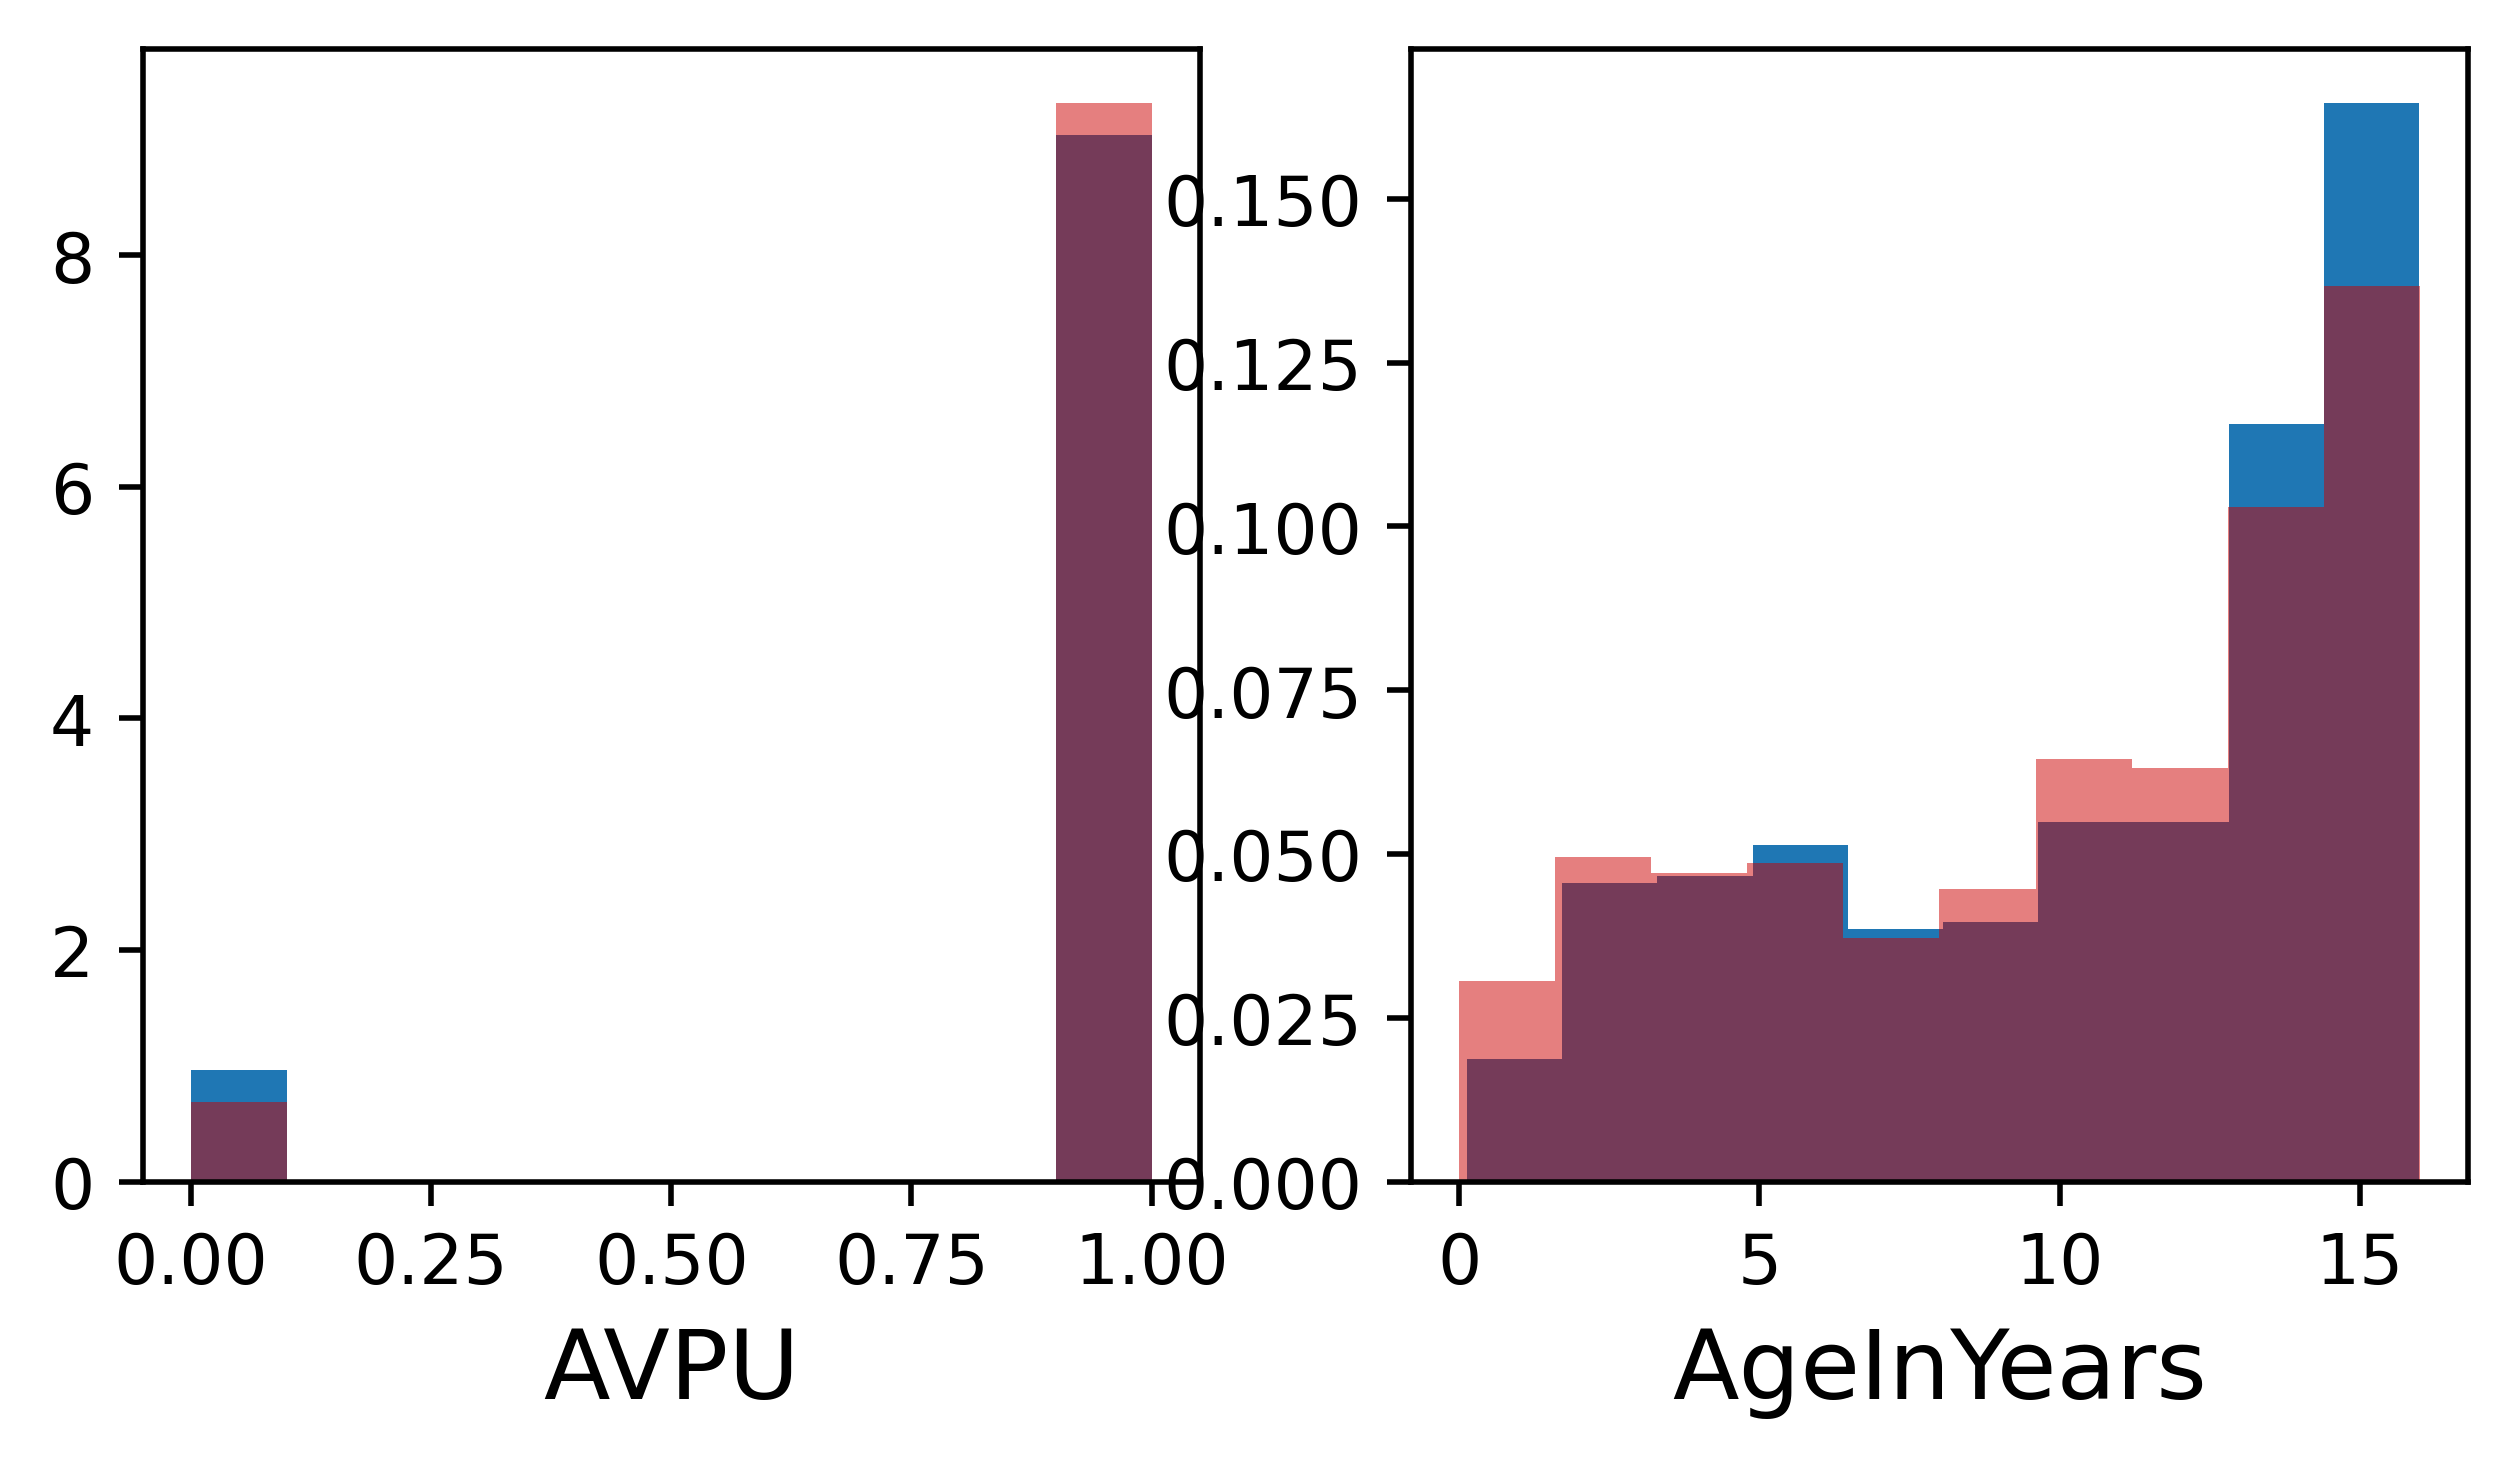

In [66]:
feats_numerical = list(cont_df.columns)
# feats_categorical = ['AbdTenderDegree', 'Race', 'MOI']
R, C, = 1, 2
plt.figure(figsize=(6, 3), dpi=500)
for i in range(len(feats_numerical)):
    plt.subplot(R, C, i + 1)
    feat = feats_numerical[i]
    plt.hist(cont_df[cont_df[outcome_def] == 1][feat], density=True, alpha=1, label='pos', color=viz.cb)
    plt.hist(cont_df[cont_df[outcome_def] == 0][feat], density=True, alpha=0.5, label='neg', color=viz.cr)
    plt.xlabel(feat, fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## Here is the end of AS progress (11/26/2021)
***

# get data

In [34]:
df_train, df_tune, _ = Dataset().get_data(load_csvs=True)
df = df_train
processed_feats = df.keys().values.tolist()
print(processed_feats)
print(len(processed_feats))

['AbdDistention_no', 'AbdDistention_or_AbdomenPain_no', 'AbdDistention_or_AbdomenPain_yes', 'AbdDistention_unknown', 'AbdDistention_yes', 'AbdTenderDegree_Mild', 'AbdTenderDegree_Moderate', 'AbdTenderDegree_None', 'AbdTenderDegree_Severe', 'AbdTenderDegree_unknown', 'AbdTrauma_no', 'AbdTrauma_or_SeatBeltSign_no', 'AbdTrauma_or_SeatBeltSign_yes', 'AbdTrauma_unknown', 'AbdTrauma_yes', 'AbdomenPain_no', 'AbdomenPain_unknown', 'AbdomenPain_yes', 'Age', 'Age<2_no', 'Age<2_yes', 'CostalTender_no', 'CostalTender_yes', 'DecrBreathSound_no', 'DecrBreathSound_unknown', 'DecrBreathSound_yes', 'DistractingPain_no', 'DistractingPain_unknown', 'DistractingPain_yes', 'GCSScore', 'GCSScore_Full_no', 'GCSScore_Full_yes', 'Hypotension_no', 'Hypotension_yes', 'LtCostalTender', 'MOI_Bike collision/fall', 'MOI_Fall down stairs', 'MOI_Fall from an elevation', 'MOI_Motor vehicle collision', 'MOI_Motorcycle/ATV/Scooter collision', 'MOI_Object struck abdomen', 'MOI_Pedestrian/bicyclist struck by moving vehicle

**correlations between features**

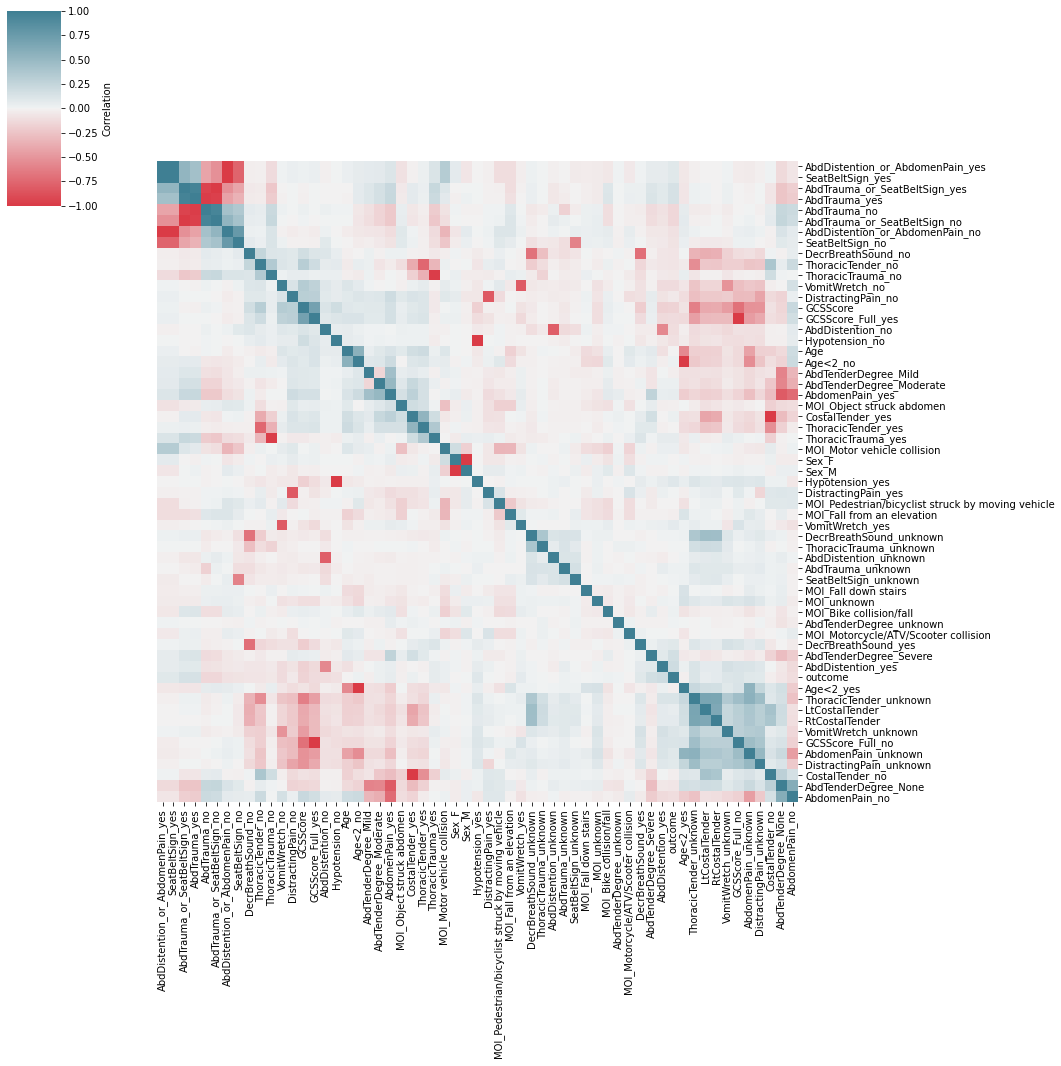

In [35]:
# corrs = df[feat_names + [outcome_def]].corr()
corrs = df[processed_feats].corr(method='pearson')
corrmap = sns.clustermap(corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'},
                         yticklabels=True,
                         figsize=(15, 15))
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)

plt.show()
# plt.savefig('results/corrplot.png', dpi=300, bbox_inches='tight')

**individual correlations with outcome**

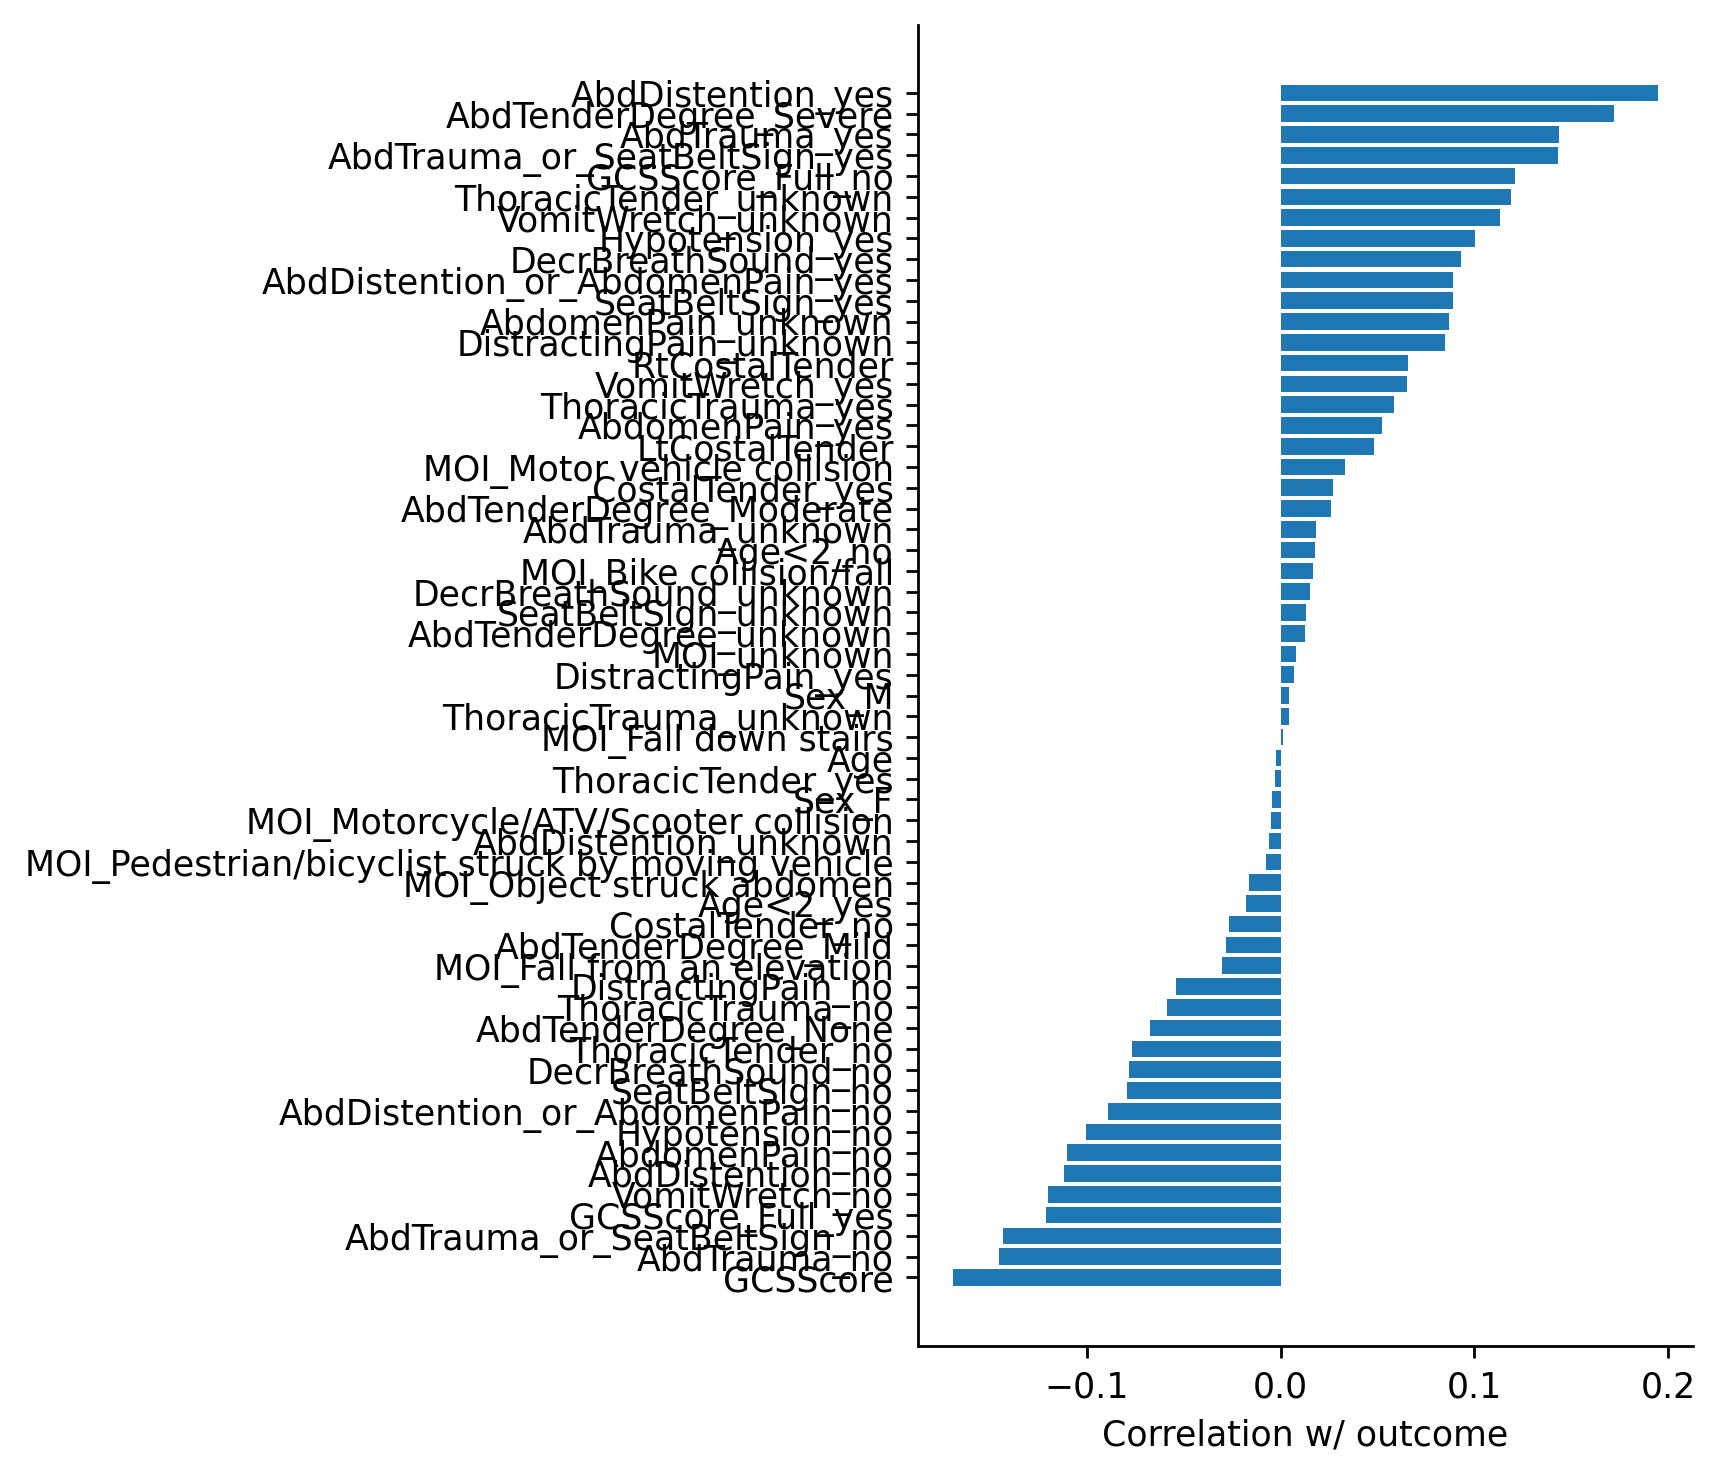

In [36]:
plt.figure(dpi=250, figsize=(4, 7))
vals = corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:-1], vals[args][:-1])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

**subgroup risks (with sizes)**

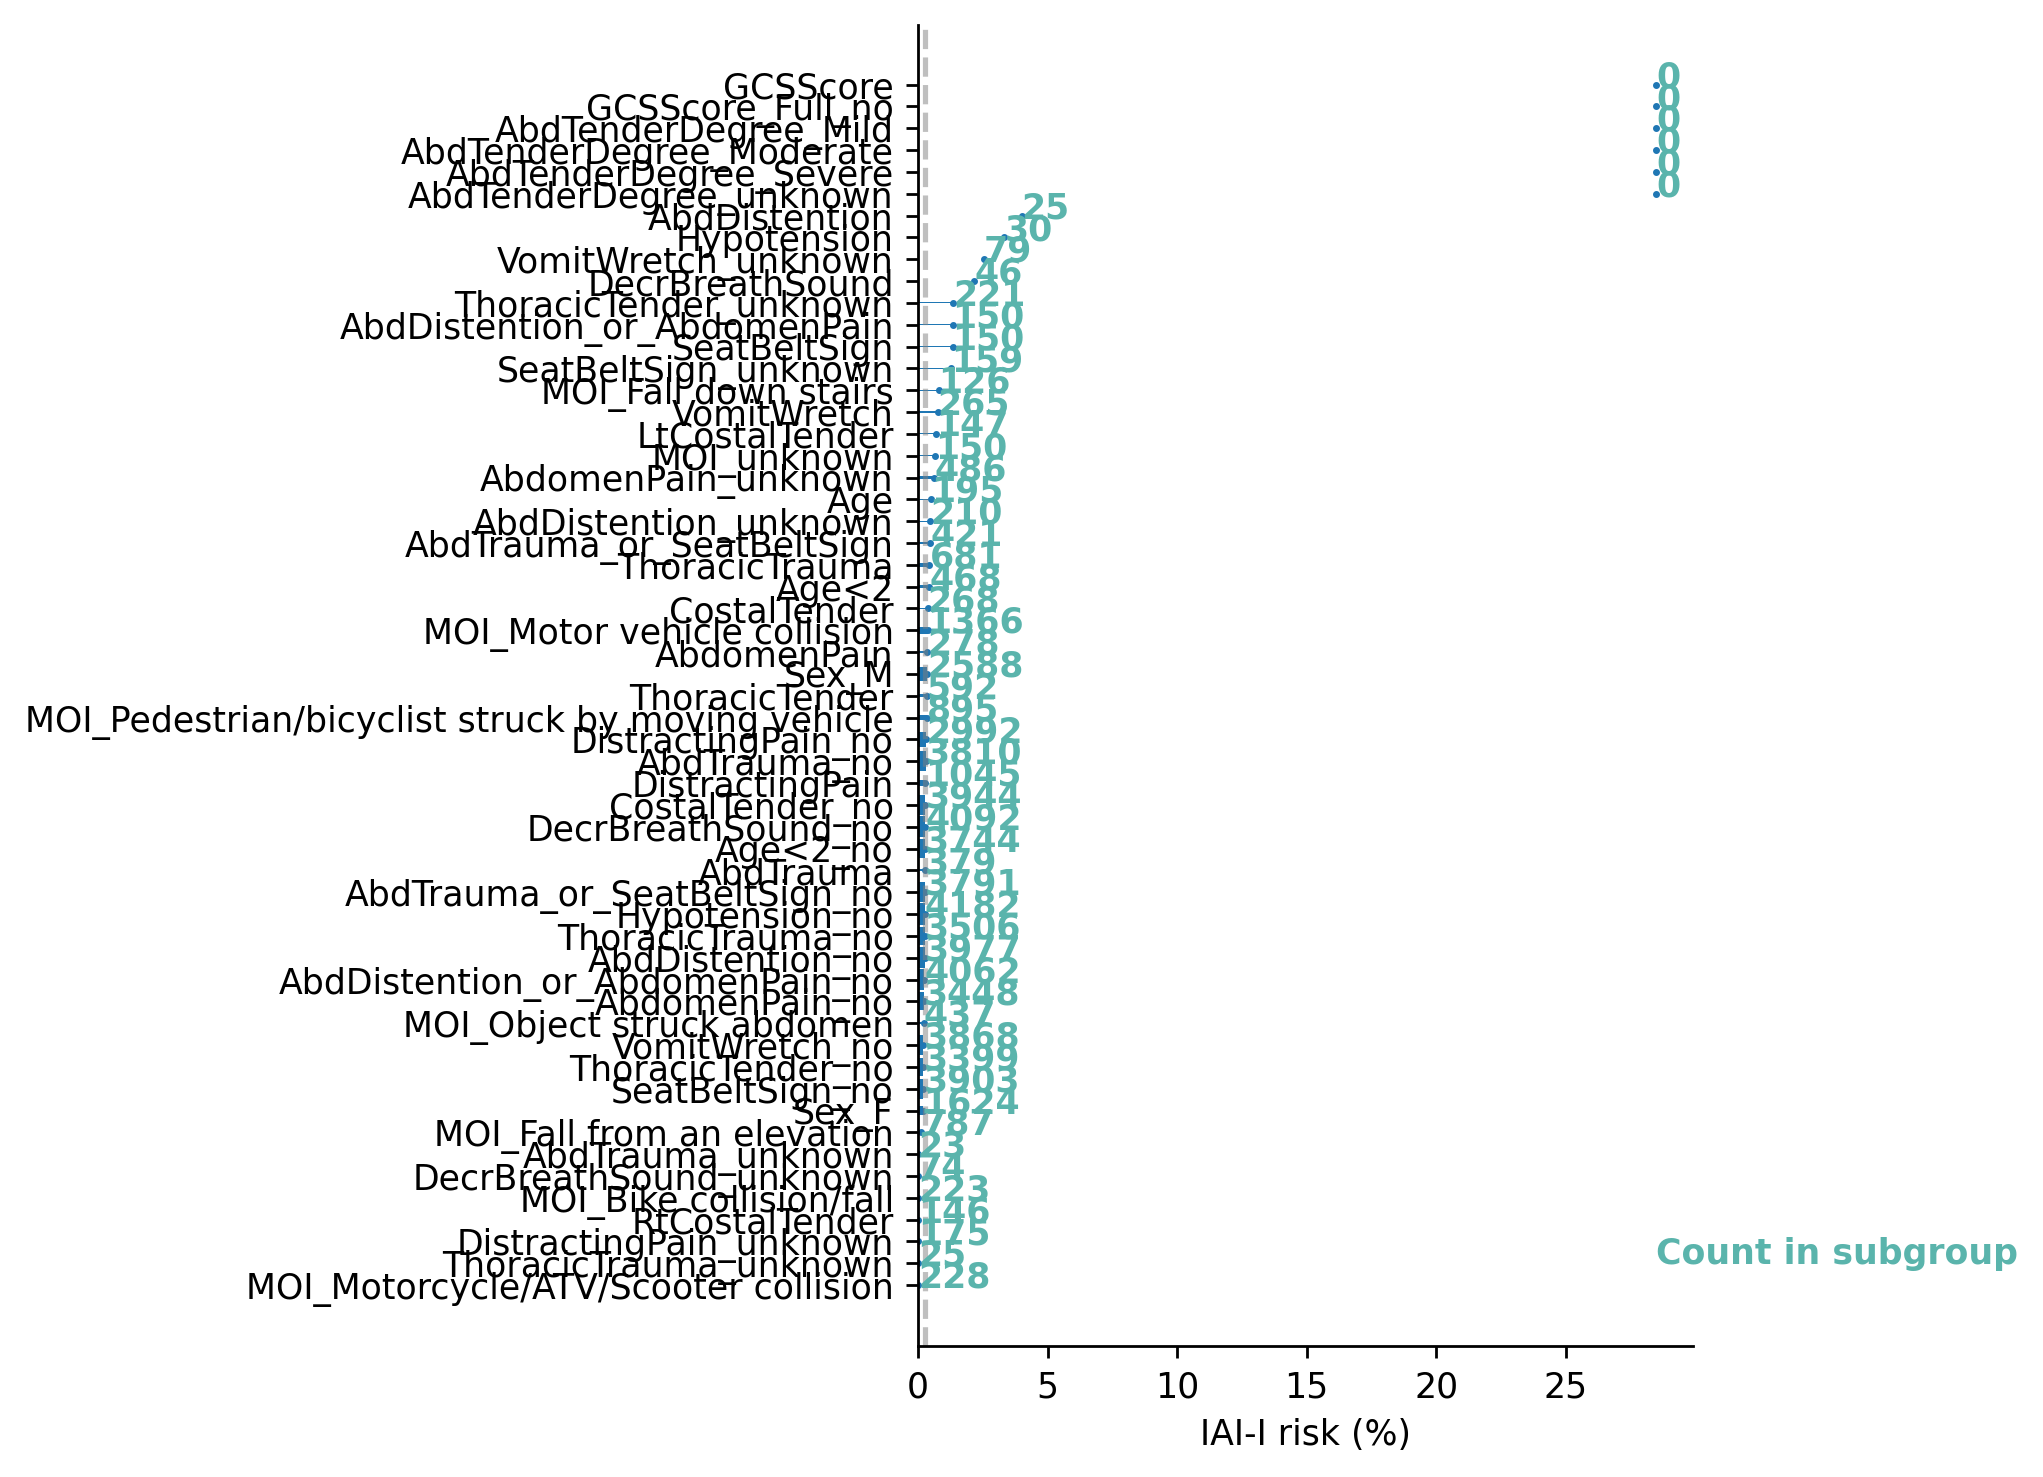

In [37]:
def plot_subgroup_risks(df, head=None, tail=None):
    plt.figure(dpi=250, figsize=(4, 7))
    ks = np.array([k for k in df.keys()
                   if not k == outcome_def])
    mean_risk_baseline = df[outcome_def].mean() * 100
    if head is not None or tail is not None:
        ks = np.array([k for k in ks
                       if np.sum(df[k]) >= 10
                       and np.abs(np.mean(df[k]) - mean_risk_baseline) > 1
                       and not np.sum([df[k] == 1]) == 0])  # should have at least one IAI-I
    vals = np.array([np.mean(df[outcome_def][df[k] == 1]) for k in ks])
    vals[np.isnan(vals)] = mean_risk_baseline
    counts = np.array([np.sum([df[k] == 1]) for k in ks])
    args = np.argsort(vals)
    if head is not None:
        args = args[:head]
    if tail is not None:
        args = args[-tail:]
    labs = ks[args]
    vals = vals[args] * 100
    counts = counts[args]
    counts_norm = counts / np.nanmax(counts)
    ax = plt.subplot(111)
    plt.plot(vals, np.arange(vals.size), 'o', ms=1)
    plt.barh(y=np.arange(vals.size), width=vals, height=1.0 * counts_norm)
    plt.yticks(np.arange(vals.size), [lab.replace('_yes', '') for lab in labs])
    for i, (v, c) in enumerate(zip(vals, counts)):
        ax.text(v, i - 0.1, str(c), color=viz.cg, fontweight='bold')
    plt.axvline(mean_risk_baseline, color='gray', linestyle='--', alpha=0.5)
    ax.text(vals.max(), 1, 'Count in subgroup', color=viz.cg, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('IAI-I risk (%)')
    plt.show()


# plot_subgroup_risks(df[processed_feats + [outcome_def]])
# dd = df[(df['AbdTenderDegree_None']==1) & (df['GCSScore_Full_yes'] == 1)] # low-risk group left to split
# plot_subgroup_risks(dd[[k for k in processed_feats if not k in ['AbdTenderDegree_None', 'GCSScore_Full_yes']] + [outcome_def]])
dd = df[(df['AbdTenderDegree_None'] == 1) & (
            df['GCSScore_Full_yes'] == 1)]  # & (df['DecrBreathSound_yes'] == 0)] # low-risk group left to split
plot_subgroup_risks(dd[[k for k in processed_feats
                        if not k in ['AbdTenderDegree_None', 'GCSScore_Full_yes']]])

**joint correlations (or risks) with outcome joint**

/Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-env/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


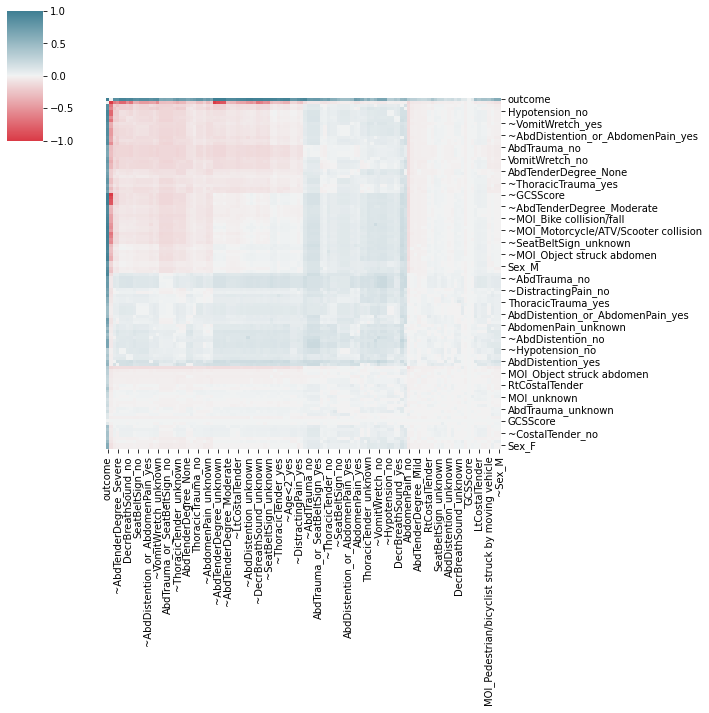

In [38]:
func = lambda x, y: np.corrcoef(x, y)[0, 1]  # corr
# func = lambda x, y: np.mean(y[x]) # frac high-risk
d = len(processed_feats)
mat = np.zeros((2 * d, 2 * d))
y = df[outcome_def]
for r in range(d):
    for c in range(d):
        xr = df[processed_feats[r]] == 1
        xc = df[processed_feats[c]] == 1
        mat[2 * r, 2 * c] = func(xr & xc, y)
        mat[2 * r + 1, 2 * c] = func(~xr & xc, y)
        mat[2 * r, 2 * c + 1] = func(xr & ~xc, y)
        mat[2 * r + 1, 2 * c + 1] = func(~xr & ~xc, y)

fs = np.array([[x, '~' + x] for x in processed_feats]).flatten()
mat[np.isnan(mat)] = 0
matt = pd.DataFrame(mat, index=fs, columns=fs)
vabs = np.max([np.abs(np.min(mat)), np.max(mat)])
vmin = -vabs
cmap = viz.cmap_div
if np.min(mat) >= 0:
    vmin = 0
    cmap = 'Blues'
corrmap = sns.clustermap(matt, cmap=cmap, vmin=vmin, vmax=vabs,
                         dendrogram_ratio=0.2, figsize=(10, 10), )
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)
#                row_cluster=False, col_cluster=False)
# plt.savefig('dendrogram.png', dpi=400)
# plt.tight_layout()
plt.show()

# features scatter plots

## continuous features

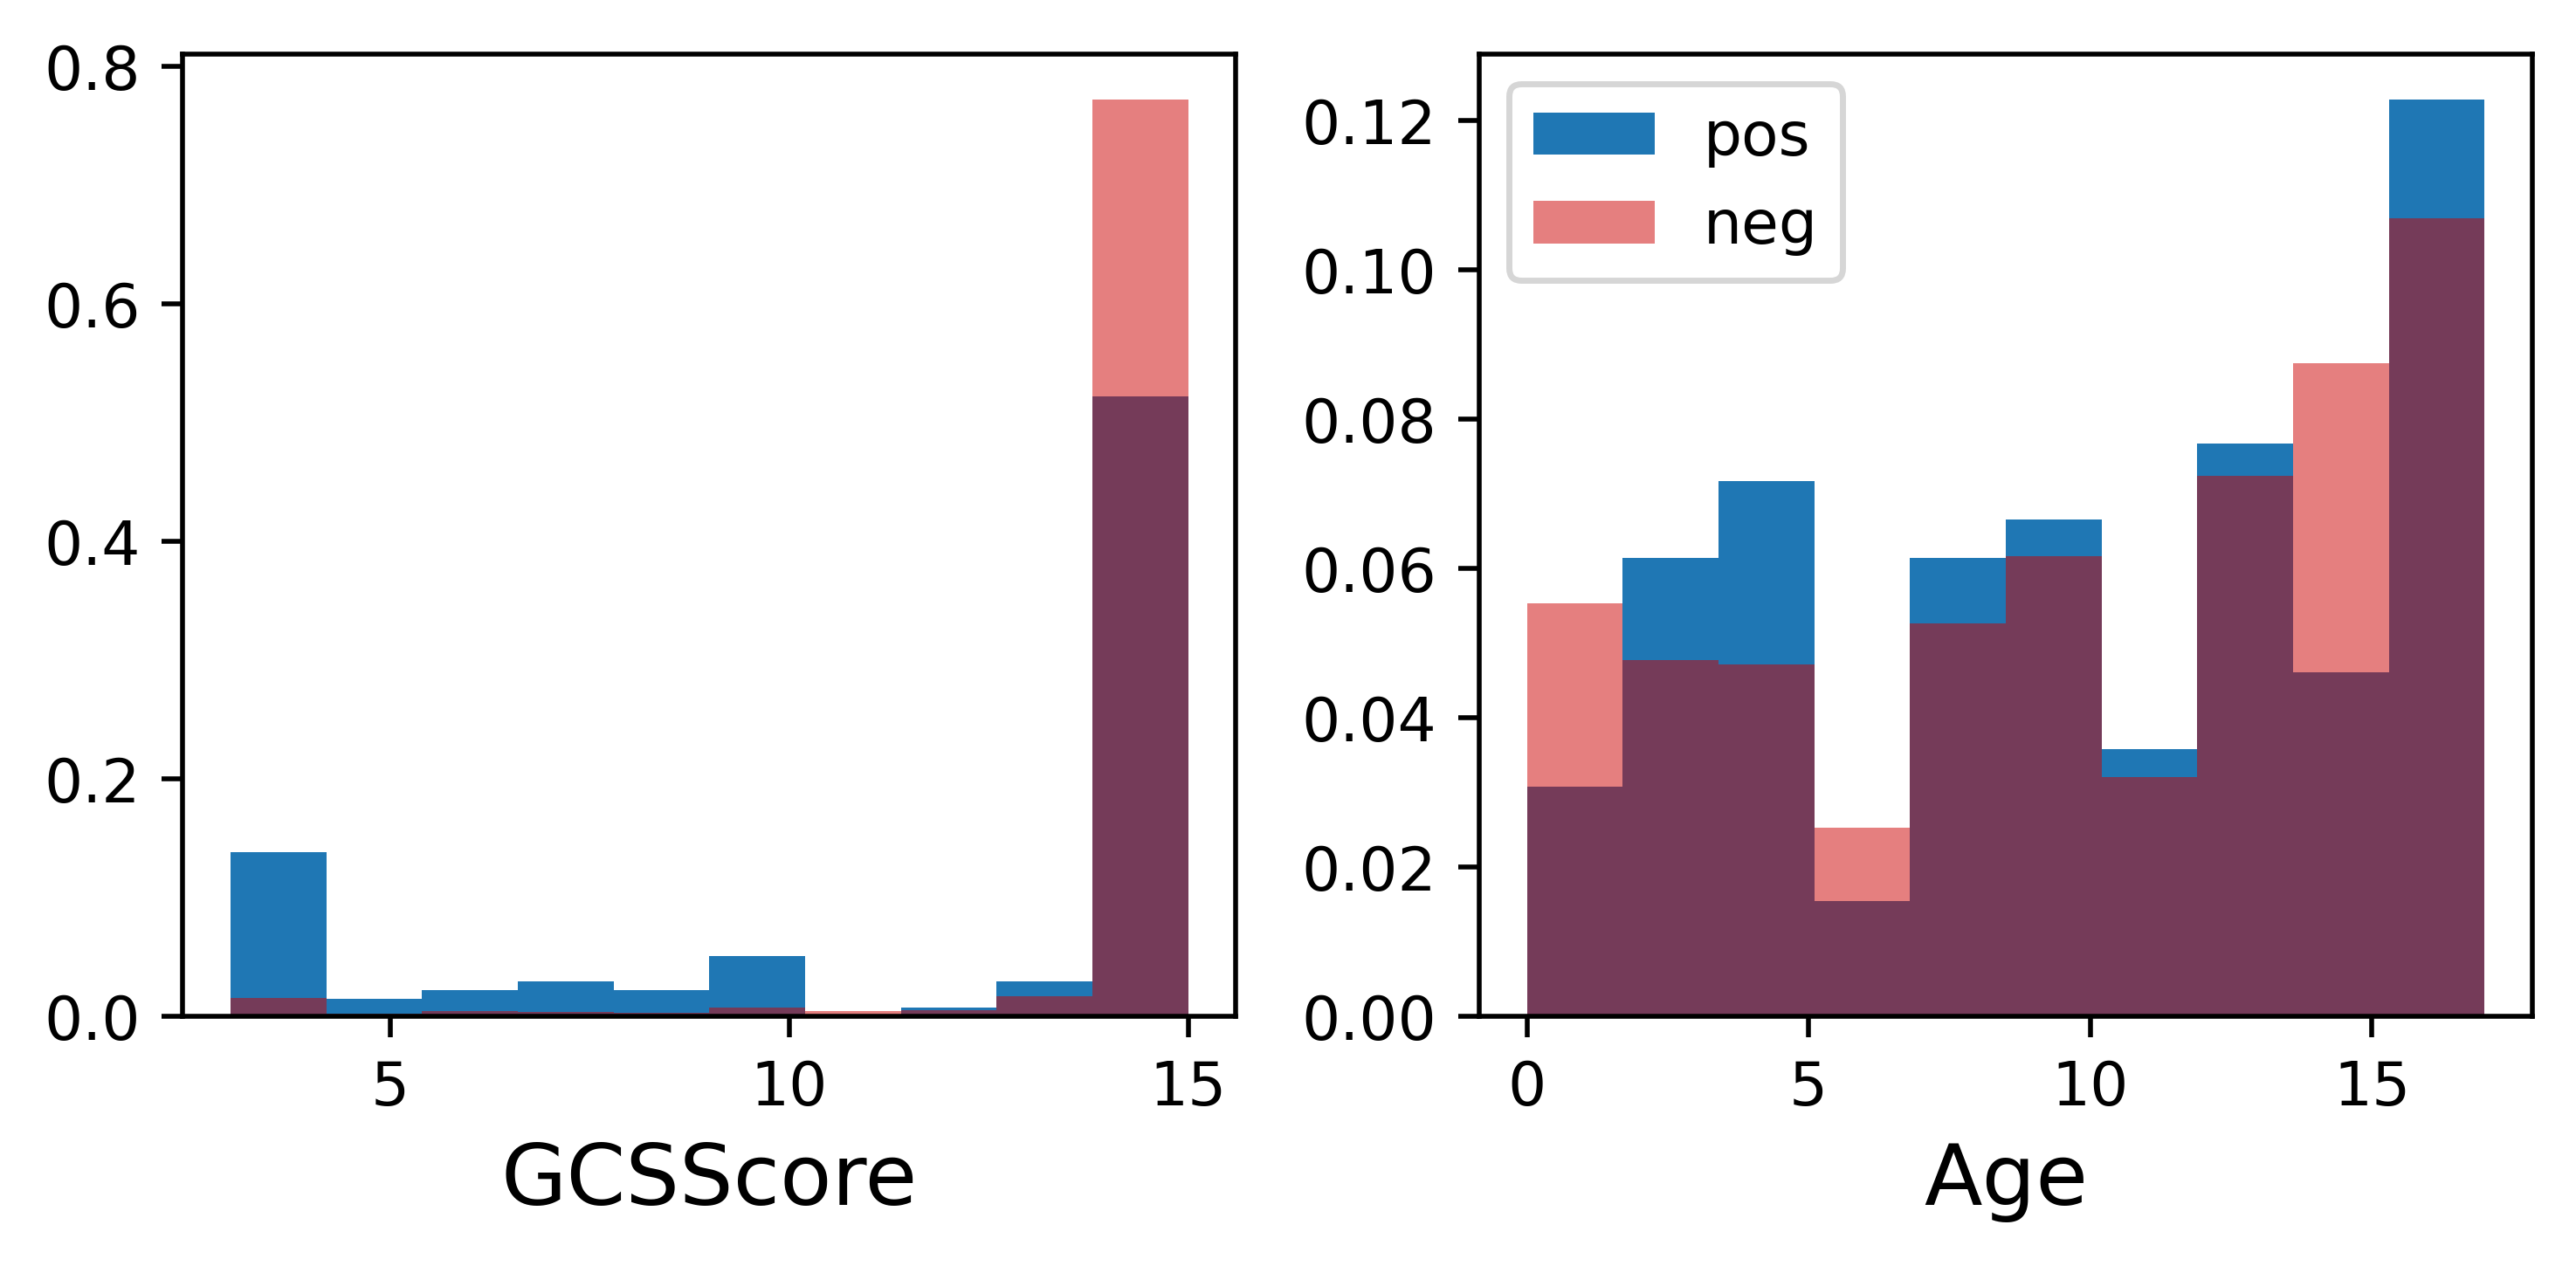

In [39]:
feats_numerical = ['GCSScore', 'Age']
# feats_categorical = ['AbdTenderDegree', 'Race', 'MOI']
R, C, = 1, 2
plt.figure(figsize=(6, 3), dpi=500)
for i in range(len(feats_numerical)):
    plt.subplot(R, C, i + 1)
    feat = feats_numerical[i]
    plt.hist(df[df[outcome_def] == 1][feat], density=True, alpha=1, label='pos', color=viz.cb)
    plt.hist(df[df[outcome_def] == 0][feat], density=True, alpha=0.5, label='neg', color=viz.cr)
    plt.xlabel(feat, fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

**we can cut GCSScore as whether it is 15 or not (14 is already pretty bad)**

In [40]:
feat = 'GCSScore'
print(np.unique(df[df[outcome_def] == 1][feat], return_counts=True))
print(np.unique(df[df[outcome_def] == 0][feat], return_counts=True))

(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12., 13., 14., 15.]), array([18,  1,  2,  3,  4,  3,  3,  4,  1,  4,  9, 63]))
(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]), array([ 119,   13,   16,   36,   31,   23,   35,   27,   37,   41,  145,
        372, 6216]))


## scatter plots

/Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/D

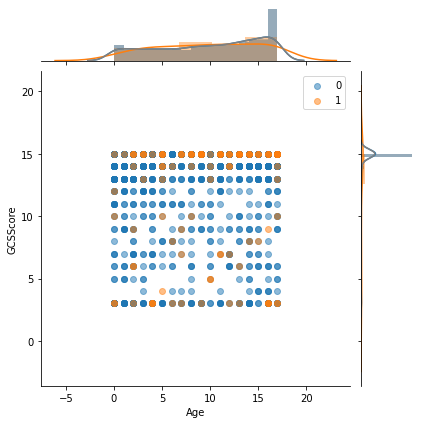

In [41]:
viz.jointplot_grouped('Age', 'GCSScore', 'outcome', df)

/Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/D

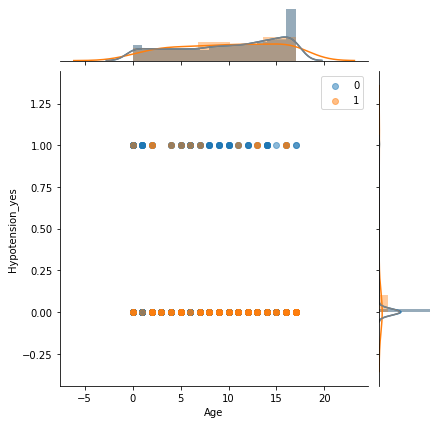

In [42]:
viz.jointplot_grouped('Age', 'Hypotension_yes', 'outcome', df)